Create volumes ```python -m dubinstracking volumes --out data/environments/paper_slow/ --csv data/environments/paper_slow/path.csv --radius 400 --alt 300 --cutoff 20e6 --map data/uptownCharlotte.obj```

Create orbits ```python -m dubinstracking circles --volumes data/environments/paper_slow/volumes.json --out data/environments/paper_slow/ --tspeed 5.0 --uavspeed 20.0 --uavturn 50.0```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from scipy.interpolate import interp1d
from scipy.optimize import minimize, minimize_scalar
import os
import json

if 'REPO_PATH' not in locals():
    os.chdir('../')
    REPO_PATH = os.getcwd()

print(REPO_PATH)

from dubinstracking.pathplanning import MorphingOrbit, OrbitFactory
from dubinstracking.controller import VectorFieldController
plt.rcParams.update({'font.size': 8})

/mnt/c/Users/chagu/repos/DubinsVisibilityTracking


In [2]:
with open('data/environments/paper_slow/circles.json') as f:
    orbits = [OrbitFactory.fromJson(item) for item in json.load(f)]
speed = orbits[0].speed
uLim = .02 * speed
m = orbits[0]
for i, orbit in enumerate(orbits):
    if m.radius(0) > orbit.radius(0):
        m = orbit
        ii = i
orbit = m
g_0 = m.g_0


if ii < len(orbits) - 1:
    dp = np.linalg.norm(orbits[ii + 1].g_0 - orbits[ii].g_0)
    vp = np.linalg.norm(orbits[ii].g_dot_0)
    t = dp / vp
    drp = (orbits[ii + 1].radius(0) - orbits[ii].radius(0)) / t
else:
    drp = 0

radius_f = lambda x, t: orbit.radius(t)
radius_dot_f = lambda x, t: drp 
vel = orbit.g_dot_0
g_v = np.linalg.norm(orbit.g_dot_0)
beta = 1
print(radius_f(0, 0), radius_dot_f(0, 0))
def controller(y):
    x = y[:3]
    def u(x, t):
        radius = radius_f(x, t)
        radius_dot = radius_dot_f(x, t)
        g = np.array([vel[0]  * t, vel[1] * t]) + g_0
        r = np.sqrt((x[0] - g[0]) ** 2 + (x[1]- g[1]) ** 2)
        e_r = np.array([(x[0] - g[0]), (x[1] - g[1])]) / r
        e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r

        G = (speed - g_v + np.abs(radius_dot)) * 2 / np.pi * np.arctan(beta * (r - radius))
        H = np.sqrt(speed ** 2 - (-G + np.dot(vel, e_r) + radius_dot) ** 2)

        ctrl = (-G + np.dot(vel, e_r) + radius_dot) * e_r + H * e_theta
        return ctrl

    def psi_dot(x, t):
        radius = radius_f(x, t)
        radius_dot = radius_dot_f(x, t)
        g = np.array([vel[0]  * t, vel[1] * t]) + g_0
        r = np.sqrt((x[0] - g[0]) ** 2 + (x[1]- g[1]) ** 2)
        e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r
        u_theta = np.dot(e_theta, u(x, t))
        theta_dot = u_theta / r - np.dot(vel, e_theta) / r
        dot_phi_p = -4 / np.pi ** 2 * beta * np.arctan(beta * (r - radius)) * ((speed - g_v - np.abs(radius_dot)) ** 2) / (1 + beta ** 2 * (r - radius) ** 2)
        return dot_phi_p / u_theta + r * theta_dot ** 2 / (u_theta)

    def invert(x, t):
        g = np.array([vel[0]  * t, vel[1] * t]) + g_0
        radius = radius_f(x, t)
        radius_dot = radius_dot_f(x, t)
        r = np.sqrt((x[0] - g[0]) ** 2 + (x[1]- g[1]) ** 2)
        e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r
        e_r = np.array([x[0] - g[1], x[1] - g[1]]) / r
        u_theta = np.dot(e_theta, u(x, t))
        
        theta = np.arctan2(u(x, t)[1], u(x, t)[0])
        psi = x[2]
        # psi_d = (theta - psi + np.pi) % (2 * np.pi) - np.pi
        psi_d = psi
        a = (np.dot(vel, e_r) + radius_dot) * ((1 - np.cos(-psi_d))/(-psi_d) if np.abs(psi_d) > 1e-6 else 0)
        b = u_theta * (np.sin(-psi_d) / -psi_d if np.abs(psi_d) > 1e-6 else 1) 
        c = (beta * 2 / np.pi * np.arctan(beta * (r - radius)) / (1 + beta ** 2 * (r - radius) ** 2))
        return (a + b) * c
    return psi_dot(x, 0) + invert(x, 0)



85.94726562500001 1.2988281249999962


In [3]:
n = 51
m = 11
x = np.linspace(-250, 50, n)
y = np.linspace(-150,150, n)
psi = np.linspace(-np.pi, np.pi, m)
zz = np.zeros([n, n, m])

beta = .025

for i in range(x.shape[0]):
    print(f'{i}/{x.shape[0]}', end='\r')
    for j in range(y.shape[0]):
        X = np.array([x[i], y[j]])
        dr = np.linalg.norm(X - g_0)  - radius_f(0, 0)
        # if  dr <= 0:
        #     continue
        for k in range(psi.shape[0]):
            X = np.array([x[i], y[j], psi[k]])
            zz[i, j, k] = controller(X)



In [4]:
invalid = np.ones_like(zz, dtype=np.bool)
for i in range(x.shape[0]):
    print(f'{i}/{x.shape[0]}', end='\r')
    for j in range(y.shape[0]):
        X = np.array([x[i], y[j]])
        dr = np.linalg.norm(X - g_0)  - radius_f(0, 0)
        invalid[i, j, :] = dr <= - .2 * radius_f(0, 0)

-136.0 -60.0 -3.141592653589793 0.4923445809079785


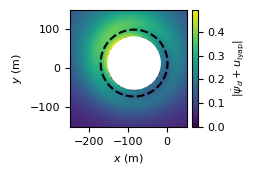

In [5]:
fig = plt.figure(figsize=(4,3))

zzz = np.copy(zz)
zzz[invalid] = 0
zzz = np.flip(zzz, axis=1)

ax = fig.add_subplot(121)
theta = np.linspace(-np.pi, np.pi)
ax.plot(np.cos(theta) * radius_f(0, 0) + g_0[0], np.sin(theta) * radius_f(0, 0) + g_0[1], 'k--')
ax.add_patch(pch.Circle(g_0, radius_f(0, 0) * .8, fc='w'))
im = ax.imshow(np.max(np.abs(zzz), axis=2).T, extent=[x.min(), x.max(), y.min(), y.max()])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cb = fig.colorbar(im, cax=cax)
cb.set_label(r'$|\dot{\psi}_d + u_{\rm lyap}|$')
ax.set_aspect('equal', 'datalim')
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')


i, j, k = np.unravel_index(np.argmax(zzz), zz.shape)
plt.tight_layout()
print(x[i], y[j], psi[k], np.max(zzz))
fig.savefig(f'notebooks/figures/controller_bounds.pdf', bbox_inches='tight')

In [6]:
minimize(lambda x: -controller(x), [x[i] - 20, y[j] + 20, np.pi / 7], 
    bounds=[(-250, 50), (-150, 150), (-2 * np.pi, 2 * np.pi)],
    constraints=[{'type': 'ineq', 'fun': lambda x: (x[0] - g_0[0]) ** 2 + (x[1] - g_0[1]) ** 2 - radius_f(0, 0) ** 2}]
)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.378408415184069
       x: [-1.486e+02  8.998e+01  1.671e-01]
     nit: 34
     jac: [-1.050e-05  5.659e-06  1.575e-04]
    nfev: 141
    njev: 34

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.4119492798415709
       x: 0.7653789260684207
     nit: 32
    nfev: 35


np.float64(0.39269908169872414)

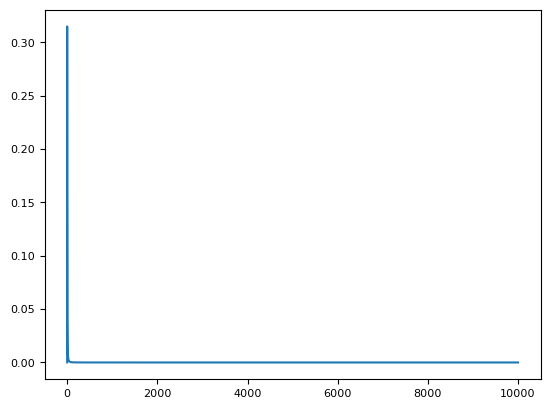

In [7]:
r = np.logspace(-2, 4, 1000)
beta = 1
plt.plot(r, np.arctan(beta * r) ** 2 / (1 + beta ** 2 *  r ** 2))

v = minimize_scalar(lambda r: - np.arctan(beta * r) / (1 + beta ** 2 *  r ** 2), [0, 1e4])
print(v)
np.arctan(1) / (1 + 1)

/tmp/ipykernel_8010/110976290.py:2: RuntimeWarning: divide by zero encountered in divide
  return (b * np.sin(a) + np.sqrt(1 - (b * np.cos(a) + c) ** 2)) ** 2 / ((d + v * c * t) * np.sqrt(1 - (b * np.cos(a) + c) ** 2))
/tmp/ipykernel_8010/110976290.py:7: RuntimeWarning: divide by zero encountered in divide
  p2 = 2 * b * (np.cos(a) + (np.sin(a) * (b * np.cos(a) + c)) / q1)
/tmp/ipykernel_8010/110976290.py:9: RuntimeWarning: divide by zero encountered in divide
  p4 = b * np.sin(a) * (b * np.cos(a) + c) * p1 / (q2 * (1 - (b * np.cos(a) + c) ** 2) ** (3 / 2))
/tmp/ipykernel_8010/110976290.py:11: RuntimeWarning: invalid value encountered in subtract
  return p1 * (p2 / p3  - p4)
/tmp/ipykernel_8010/110976290.py:18: RuntimeWarning: divide by zero encountered in divide
  p2 = -2 * ( b * np.cos(a) + c) / (q2 * q3)
/tmp/ipykernel_8010/110976290.py:19: RuntimeWarning: divide by zero encountered in divide
  p3 = (b * np.cos(a) + c) * p1 / (q2 * q1)
/tmp/ipykernel_8010/110976290.py:20: RuntimeWa

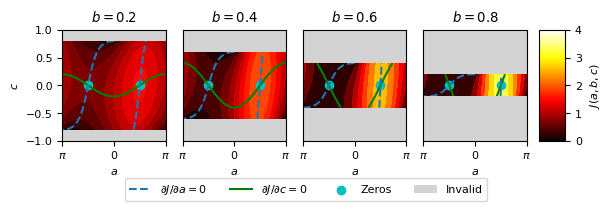

In [8]:
def J(a, b, c, d, v, t):
    return (b * np.sin(a) + np.sqrt(1 - (b * np.cos(a) + c) ** 2)) ** 2 / ((d + v * c * t) * np.sqrt(1 - (b * np.cos(a) + c) ** 2))
def Ja(a, b, c, d, v, t):
    q1 = np.sqrt(1 - (b * np.cos(a) + c) ** 2)
    q2 = (c * v * t + d)
    p1 = (b * np.sin(a) + q1)
    p2 = 2 * b * (np.cos(a) + (np.sin(a) * (b * np.cos(a) + c)) / q1)
    p3 = q2 * q1
    p4 = b * np.sin(a) * (b * np.cos(a) + c) * p1 / (q2 * (1 - (b * np.cos(a) + c) ** 2) ** (3 / 2))

    return p1 * (p2 / p3  - p4)

def Jc(a , b, c, d, v, t):
    q1 = np.sqrt(1 - (b * np.cos(a) + c) ** 2)
    q2 = (c * v * t + d)
    q3 = 1 - (b * np.cos(a) + c) ** 2
    p1 = (b * np.sin(a) + q1)
    p2 = -2 * ( b * np.cos(a) + c) / (q2 * q3)
    p3 = (b * np.cos(a) + c) * p1 / (q2 * q1)
    p4 = - v * t * p1 / (q2 ** 2 * q1)

    return p1 * (p2 + p3 + p4)



fig = plt.figure(layout='constrained', figsize=(6, 1.75))
axes = fig.subplots(1, 5, width_ratios=[20, 20, 20, 20, 5])
b = [.2, .4, .6, .8]
norm = Normalize(0, 4)

for ax, b in zip(axes[:4], b):
    n = 1000
    a, c = np.meshgrid(np.linspace(-np.pi, np.pi, n), np.linspace(-1 + b, 1 - b, n))

    zz = J(a, b, c, 1, 1, 0)
    zza = Ja(a, b, c, 1, 1, 0)
    zzc = Jc(a, b, c, 1, 1, 0)

    ax.contourf(a, c, zz, cmap='hot', norm=norm)
    zeros = ax.scatter([-np.pi / 2, np.pi / 2], [0, 0], color='c')
    djda = ax.contour(a, c, zzc, levels=[0], colors=['g'])
    djdc = ax.contour(a, c, zza, levels=[0], colors=['tab:blue'], linestyles='--')
    ax.add_patch(pch.Rectangle([-np.pi, -1], 2 * np.pi, b, fc='lightgray', zorder=2))
    ax.add_patch(pch.Rectangle([-np.pi, 1 - b], 2 * np.pi, b, fc='lightgray', zorder=2))
    ax.set_ylim([-1, 1])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_title(r'$b = {0}$'.format(b))
    ax.set_xticks([-np.pi, 0, np.pi], [r'$\pi$', 0, r'$\pi$'])
    ax.set_xlabel(r'$a$')

for ax in axes[1:4]:
    ax.yaxis.set_visible(False)

axes[0].set_ylabel('$c$')

fig.colorbar(ScalarMappable(norm, 'hot'), cax=axes[4], label=r'$J(a, b, c)$')

fig.legend(
    [
        Line2D([0], [0], color='tab:blue', ls='--'),
        Line2D([0], [0], color='g'),
        zeros,
        pch.Rectangle([-np.pi, -1], 2 * np.pi, b, fc='lightgray', zorder=2)
    ],
    [
        r'$\partial J / \partial a = 0$',
        r'$\partial J / \partial c = 0$',
        'Zeros',
        'Invalid'
    ],
    loc='lower center',
    ncol=4,
    bbox_to_anchor=(.5, -.15)
)

fig.savefig('notebooks/figures/jacobian_contours.pdf', bbox_inches='tight')

In [9]:
controller = VectorFieldController(7e-2, 20, .02)
all_time = [0]
t_i = 0
t_f = 0
x_0 = [0, 100, -np.pi]
n = len(orbits)
for orbit in orbits:
    orbit.speed = speed

state_hist = [x_0 + [0 , 0, 0]]
trajectory = [orbits[0].g_0]
radius = [orbits[0].radius(0)]
all_control = [[0, 0]]

for i in range(len(orbits[:n]) - 1):
    distance = np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0)
    delta = distance / np.linalg.norm(orbits[i].g_dot_0)
    t_f = t_i + delta
    orbit = MorphingOrbit(orbits[i], orbits[i + 1], t_i, t_f)
    time, state, path, control = controller.solve(orbit, t_i, t_f, x_0, 1e-2)
    state_hist += state.tolist()[1:]
    all_time += time.tolist()[1:]
    trajectory += path.tolist()[:-1]
    all_control += control.tolist()[:-1]
    radius += [orbit.radius(0, t) for t in time[1:]]
    x_0 = state_hist[-1][:len(x_0)]
    t_i = t_f
    print(f'orbit {i + 1}/{len(orbits)}', end='\r')

state_hist = np.array(state_hist)
trajectory = np.array(trajectory)
dist = state_hist[:, :2] - trajectory
theta = np.arctan2(dist[:, 1], dist[:, 0])
all_control = np.array(all_control)
all_time = np.array(all_time)

In [10]:
with open('data/uptownCharlotte.json') as f:
    city = [Polygon(item) for item in json.load(f)]
with open('data/environments/paper_slow/volumes.json') as f:
    volumes = json.load(f)
    visibility = [np.array(item['polygon']) for item in volumes]
    visibility_points = np.array([item['point'] for item in volumes])

poi_speed = np.linalg.norm(orbits[0].g_dot_0)
radius_f = interp1d(all_time, radius)
trajectory_fx = interp1d(all_time, trajectory[:, 0])
trajectory_fy = interp1d(all_time, trajectory[:, 1])
state_hist_fx = interp1d(all_time, state_hist[:, 0])
state_hist_fy = interp1d(all_time, state_hist[:, 1])

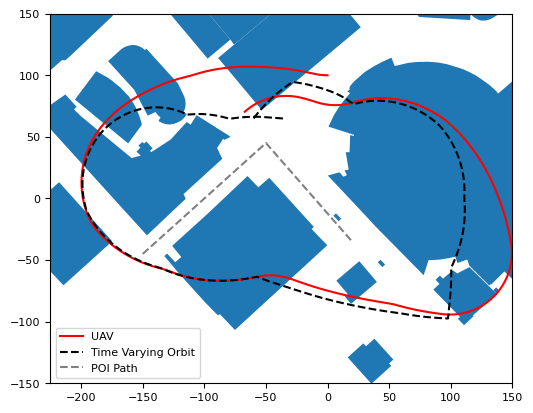

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(state_hist[:, 0], state_hist[:, 1], 'r')
ax.plot(radius * np.cos(theta) + trajectory[:, 0], radius * np.sin(theta) + trajectory[:, 1], 'k--')
ax.plot(trajectory[:, 0], trajectory[:, 1], '--', color='gray')
ax.legend(['UAV', 'Time Varying Orbit', 'POI Path'])

for building in city:
    ax.add_patch(pch.Polygon(building.exterior.coords))

ax.set_ylim([-150, 150])
ax.set_xlim([-225, 150])
ax.set_aspect('equal', 'box')

In [12]:
def getVisibility(t):
    length = 0
    i = 0
    while i < len(visibility) - 1:
        l = np.linalg.norm(visibility_points[i + 1, :] - visibility_points[i, :])
        if length / poi_speed <= t and t < (length + l) / poi_speed:
            return visibility[i], visibility[i + 1]
        i += 1
        length += l
    return visibility[-2], visibility[-1]

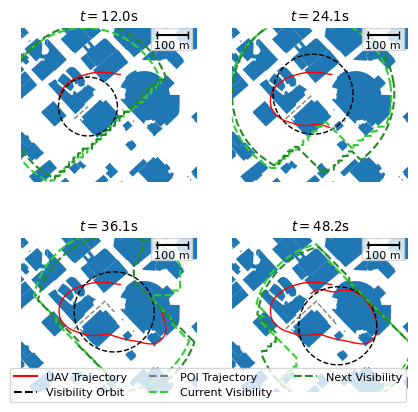

In [13]:
fig = plt.figure(figsize=(5, 5))
n = 4
axes = fig.subplots(2, 2).reshape([n])
twopi = np.linspace(0, 2 * np.pi, 100)
for i, ax in enumerate(axes):
    k = len(state_hist) * (1 + i) // n - 1
    ax.plot(state_hist[:k, 0], state_hist[:k, 1], 'r', lw=1)
    ax.plot(radius[k] * np.cos(twopi) + trajectory[k, 0], radius[k] * np.sin(twopi) + trajectory[k, 1], 'k--', lw=1)
    ax.plot(trajectory[:k, 0], trajectory[:k, 1], '--', color='gray', lw=1)
    vv0, vv1 = getVisibility(all_time[k])
    ax.plot(vv0[:, 0], vv0[:, 1], '--', color='limegreen')
    ax.plot(vv1[:, 0], vv1[:, 1], '--', color='forestgreen')
    # ax.legend(['UAV', 'Time Varying Orbit', 'POI Path'])

    for building in city:
        ax.add_patch(pch.Polygon(building.exterior.coords))

    ax.set_aspect('equal', 'box')
    ax.set_ylim([-250, 250])
    ax.set_xlim([-325, 250])
    ax.set_axis_off()
    ax.set_title(f'$t = {all_time[k]:.1f}$s')
    ax.add_patch(pch.Rectangle((100, 180), 135, 70, fc='white', ec=(.8, .8, .8), zorder=2, alpha=.8))
    ax.plot([120, 220], [230, 230], 'k-|',zorder=3)
    ax.text(110, 187, '100 m',zorder=3)

fig.legend(
    [
        Line2D([0], [0], color='r'),
        Line2D([0], [0], color='k', linestyle='--'),
        Line2D([0], [0], linestyle='--', color='gray'),
        Line2D([0], [0], linestyle='--', color='limegreen'),
        Line2D([0], [0], linestyle='--', color='forestgreen'),
    ],
    [
        'UAV Trajectory',
        'Visibility Orbit',
        'POI Trajectory',
        'Current Visibility',
        'Next Visibility'
    ],
    ncol=3,
    loc=8,
    bbox_to_anchor=(.5, .1)
)

fig.savefig(f'notebooks/figures/UAV_trajectory_big.pdf')

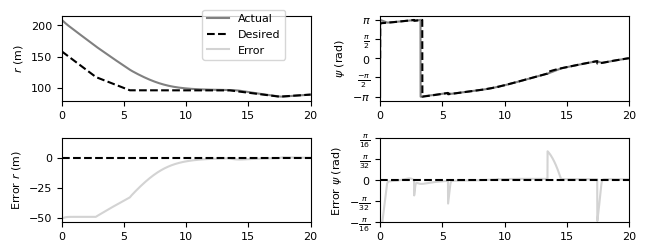

In [14]:
t_lim = 20
fig = plt.figure(figsize=(6.5, 2.5))
axes = fig.subplots(2, 2)
axes[0, 0].plot(all_time, np.linalg.norm(dist, axis=1), color='gray')
axes[0, 0].plot(all_time, radius, '--k')
axes[0, 0].set_xlim([0, t_lim])
axes[0, 0].set_ylabel('$r$ (m)')


axes[1, 0].plot(all_time, radius - np.linalg.norm(dist, axis=1), color='lightgray')
axes[1, 0].set_xlim([0, t_lim])
axes[1, 0].plot(all_time[[0, -1]], [0, 0], 'k--')
axes[1, 0].set_ylabel(r'Error $r$ (m)')

axes[0, 1].plot(all_time, (state_hist[:, 2] + np.pi) % (2 * np.pi) - np.pi, 'gray')
axes[0, 1].plot(all_time, np.arctan2(all_control[:, 1], all_control[:, 0]) ,'--k')
axes[0, 1].set_xlim([0, t_lim])
axes[0, 1].set_ylabel(r'$\psi$ (rad)')
axes[0, 1].set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], [r'$-\pi$', r'$\frac{-\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

axes[1, 1].plot(all_time, (( np.arctan2(all_control[:, 1], all_control[:, 0]) - state_hist[:, 2] + np.pi) % (2 * np.pi) - np.pi), color='lightgray')
axes[1, 1].plot(all_time[[0, -1]], [0, 0], 'k--')
axes[1, 1].set_xlim([0, t_lim])
axes[1, 1].set_ylim([-np.pi/16, np.pi/16])
axes[1, 1].set_ylabel(r'Error $\psi$ (rad)')
axes[1, 1].set_yticks([-np.pi/16, -np.pi / 32, 0, np.pi/32, np.pi / 16,], [r'$-\frac{\pi}{16}$', r'$-\frac{\pi}{32}$', '$0$', r'$\frac{\pi}{32}$', r'$\frac{\pi}{16}$'])

fig.legend([Line2D([0], [0], color='gray'), Line2D([0], [0], color='k', ls='--'), Line2D([0], [0], color='lightgray')],['Actual', 'Desired', 'Error'], loc=1, bbox_to_anchor=(.45, 1))
fig.tight_layout()
fig.savefig(f'notebooks/figures/controller_error_big.pdf')

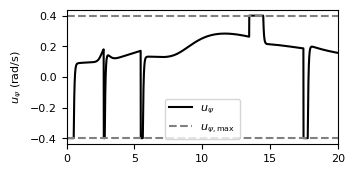

In [15]:
fig = plt.figure(figsize=(3.5, 1.75))
ax = fig.add_subplot()
ax.plot(all_time, state_hist[:, 5], 'k')
ax.set_xlim([0, t_lim])
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_ylabel(r'$u_{\psi}$ (rad/s)')
ax.plot(all_time[[0, -1]], [orbits[0].speed * controller.maxcurv] * 2, '--', color='gray')
ax.plot(all_time[[0, -1]], [-orbits[0].speed * controller.maxcurv] * 2, '--', color='gray')
ax.legend([r'$u_\psi$', r'$u_{\psi, {\max}}$'], loc='lower center')
fig.savefig('notebooks/figures/control_heading_big.pdf')